# 4.1/2 Defensive statistics & Defensive style

In [1]:
%load_ext autoreload
%autoreload 2

# standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import json
import zipfile
from pathlib import Path
import os
import sys
from IPython.display import display

# specfic soccer analysis packages
from mplsoccer import Pitch, Sbopen, VerticalPitch

# load custom functions
from src.visualization import *

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Denmark vs Slovenia 2:1 (2023-11-20)

In [2]:
match_id = "5414302"
df_events = pd.read_csv(f"./results/wyscout/{match_id}_df_events.csv", index_col=0)

### Defensive statistics

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


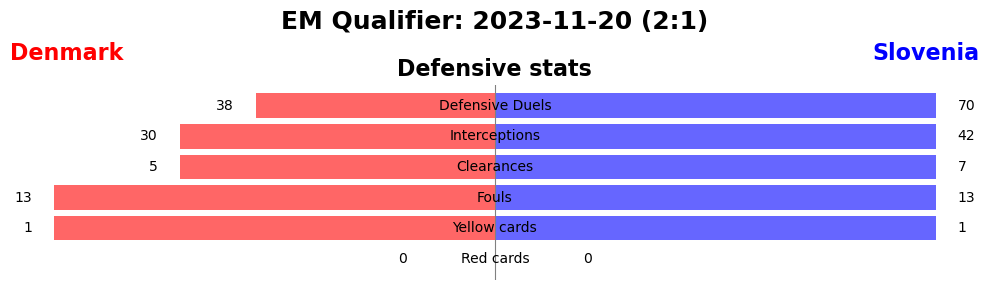

In [7]:
team_type_counts = df_events.groupby(['team.name', 'type.primary']).size().unstack(fill_value=0)

team2 = 'Denmark'
dnk_data = {'Defensive Duels': df_events[(df_events["groundDuel.duelType"] == "defensive_duel") & (df_events["team.name"] == team2)]["groundDuel.relatedDuelId"].notna().sum(),
            'Interceptions': team_type_counts.loc[team2, 'interception'],
            'Clearances': team_type_counts.loc[team2, 'clearance'],
            'Fouls': team_type_counts.loc[team2, 'infraction'],
            'Yellow cards': df_events[(df_events["team.name"] == team2) & (df_events["infraction.yellowCard"] == True)].shape[0],
            'Red cards': df_events[(df_events["team.name"] == team2) & (df_events["infraction.redCard"] == True)].shape[0],
            }

team1 = 'Slovenia'
svn_data = {'Defensive Duels': df_events[(df_events["groundDuel.duelType"] == "defensive_duel") & (df_events["team.name"] == team1)]["groundDuel.relatedDuelId"].notna().sum(),
            'Interceptions': team_type_counts.loc[team1, 'interception'],
            'Clearances': team_type_counts.loc[team1, 'clearance'],
            'Fouls': team_type_counts.loc[team1, 'infraction'],
            'Yellow cards': df_events[(df_events["team.name"] == team1) & (df_events["infraction.yellowCard"] == True)].shape[0],
            'Red cards': df_events[(df_events["team.name"] == team1) & (df_events["infraction.redCard"] == True)].shape[0],
            }

perc_categories = []

plot_stats_barchart(svn_data, dnk_data, team1_name='Slovenia', team2_name='Denmark', perc_categories=perc_categories, title='EM Qualifier: 2023-11-20 (2:1)',
                    subtitle='Defensive stats', team1_color='blue', team2_color='red',saveplt=True, savepath='plots/4-defense/defense_statistics.png')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


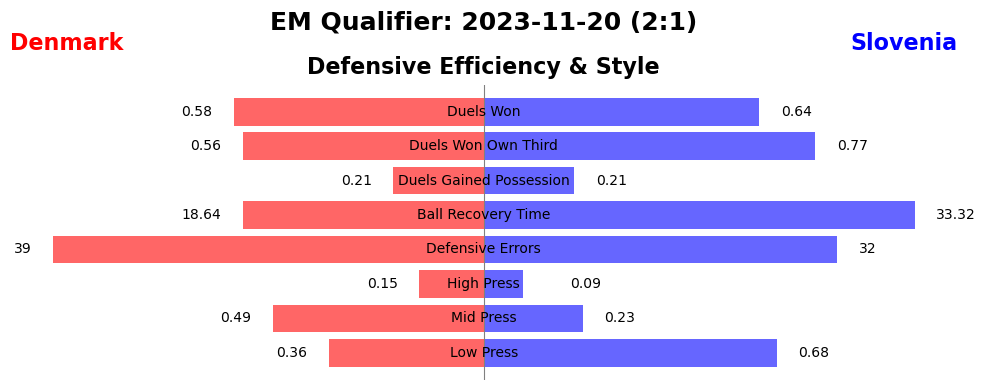

In [8]:
def calculate_defensive_efficiency(team_name, opponent_name):

    team_events = df_events[df_events["team.name"] == team_name]
    
    defensive_duels = team_events[(team_events["groundDuel.duelType"] == "defensive_duel")]
    defensive_duels_ownthird = defensive_duels[(defensive_duels["location.x"] < 33.3)]
    duels_won = defensive_duels[(defensive_duels["groundDuel.stoppedProgress"] == True) | (defensive_duels["groundDuel.recoveredPossession"] == True)].shape[0]
    duels_won_pos = defensive_duels[(defensive_duels["groundDuel.recoveredPossession"] == True)].shape[0]
    duels_won_ownthird = defensive_duels_ownthird[(defensive_duels_ownthird["groundDuel.stoppedProgress"] == True) | (defensive_duels_ownthird["groundDuel.recoveredPossession"] == True)].shape[0]
    total_events = defensive_duels.shape[0]
    total_events_ownthird = defensive_duels_ownthird.shape[0]

    # ball recovery time avg possession duration of opponent
    ball_recovery_time = df_events[(df_events["possession.team.name"] == opponent_name)]["possession.duration"].mean()

    # defensive errors = interceptions + offensive duels lost + dribbles lost in own half
    own_half = df_events[(df_events["location.x"] < 50)]
    interceptions = own_half[(own_half["type.primary"] == "interception") & (own_half["team.name"] == opponent_name)]
    offensive_duels_lost = own_half[(own_half["groundDuel.duelType"] == "offensive_duel") & (own_half["team.name"] == team_name) & (own_half["groundDuel.keptPossession"] == False)]
    dribbles_lost = own_half[(own_half["groundDuel.duelType"] == "offensive_duel") & (own_half["team.name"] == team_name) & (own_half["groundDuel.keptPossession"] == False)]
    defensive_errors = pd.concat([interceptions, offensive_duels_lost, dribbles_lost]).shape[0]

    # Pressure actions
    interceptions = team_events[(team_events["type.primary"] == "interception")]
    clearence = team_events[(team_events["type.primary"] == "clearance")]
    defensive_duels = team_events[(team_events["groundDuel.duelType"] == "defensive_duel")]
    pressures = pd.concat([interceptions, clearence, defensive_duels])

    # High press: Pressure in the opposing third
    high_press = pressures[(pressures["location.x"] > 66.6)]
    mid_press = pressures[(pressures["location.x"] > 33.3) & (pressures["location.x"] < 66.6)]
    low_press = pressures[(pressures["location.x"] < 33.3)]

    return {'Duels Won': round(duels_won / total_events, 2),
            'Duels Won Own Third': round(duels_won_ownthird / total_events_ownthird, 2),
            'Duels Gained Possession': round(duels_won_pos / total_events, 2),
            'Ball Recovery Time': round(ball_recovery_time, 2),
            'Defensive Errors': defensive_errors,
            'High Press': round(high_press.shape[0] / pressures.shape[0], 2),
            'Mid Press': round(mid_press.shape[0] / pressures.shape[0], 2),
            'Low Press': round(low_press.shape[0] / pressures.shape[0], 2),
            }


# Use the function to calculate stats for Denmark and Slovenia
dnk_data = calculate_defensive_efficiency("Denmark", "Slovenia")
svn_data = calculate_defensive_efficiency("Slovenia", "Denmark")

perc_categories = ["Duels Won", "Duels Won Own Third", "Duels Gained Possession", "High Press", "Mid Press", "Low Press"]

plot_stats_barchart(svn_data, dnk_data, team1_name='Slovenia', team2_name='Denmark', perc_categories=perc_categories, title='EM Qualifier: 2023-11-20 (2:1)',
                    subtitle='Defensive Efficiency & Style', team1_color='blue', team2_color='red', saveplt=True, savepath='plots/4-defense/defensive_efficiency_style.png')